In [97]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage

In [98]:
# name = "T_S04856"
# name = "T_S04912"
name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [99]:
clusters = 10

In [100]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [101]:
def imshow(img: np.ndarray, color_channel="rgb"):
    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

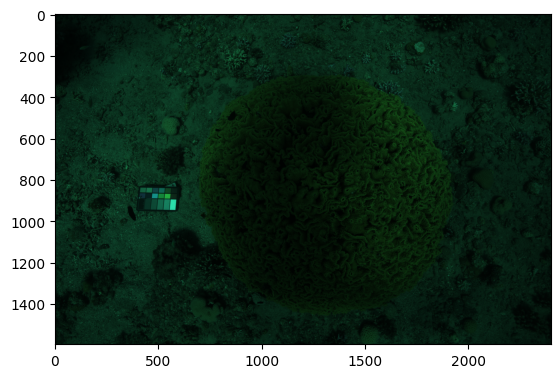

In [102]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [103]:
png.dtype

dtype('float64')

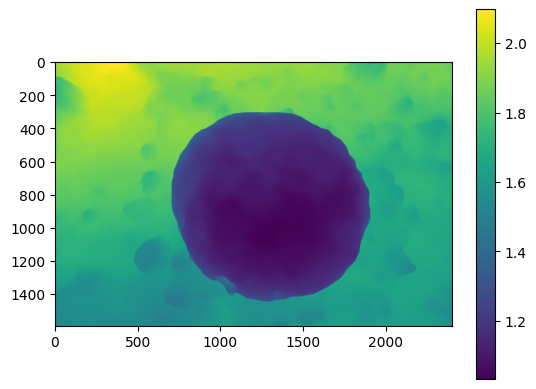

In [104]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [105]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [106]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [107]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

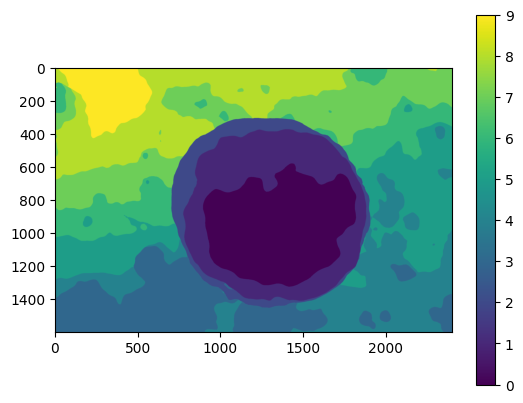

In [108]:
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
labels = np.zeros(tif_flat.shape, dtype=np.uint8)
labels[tif_flat != 0] = kmeans.labels_
labels[tif_flat == 0] = 255 # Use 255 to represent nan
means = np.array(kmeans.cluster_centers_).flatten()
means_args = np.argsort(means)

labels_new = np.zeros_like(labels)
labels_new[labels == 255] = clusters + 1

for current_label in range(clusters):
    new_label = np.nonzero(means_args == current_label)[0]
    labels_new[labels == current_label] = new_label

labels = labels_new.reshape((height, width))
imshow(labels)

In [109]:
dark_pixels = []
z_values = []

for i in range(clusters):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [110]:
dark_pixels.shape, z_values.shape

((48789, 3), (48789,))

In [111]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [112]:
z_values

array([1.11736989, 1.11718369, 1.11463082, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(48789,))

In [113]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [114]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return np.sum((B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)) ** 2)

In [115]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [116]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.27950615 1.89645553 0.81864645 2.97460552]
2.574285289238763 [0.00993586 1.78310518 0.3151935  3.81292343]
[0.79210341 1.60327102 0.05787112 1.36854779]
0.7887890222581522 [5.86852092e-02 1.42571584e-01 1.45575809e-07 1.43881559e+00]
[0.57022121 0.21391802 0.67632923 3.38320011]
1.6309468656874087 [0.33577245 0.01989787 0.32602031 3.89101457]
[0.76573147 3.63740858 0.57482348 0.28725109]
2.1096277526384304 [0.00974344 3.59523916 0.0402125  2.54167374]
[0.26152388 0.56090657 0.88214432 4.66431125]
0.9748669852587264 [0.07821532 0.09991204 0.17211351 4.47704152]
[0.6892604  1.98737729 0.40814687 3.80020061]
2.2552993802040535 [0.01220843 1.03934614 0.45232777 4.18553493]
[0.74711109 0.25522998 0.21419239 4.85757416]
0.8735318115209317 [0.47280432 0.01567228 0.18940379 4.86134153]
[0.16047334 4.62456679 0.07455623 3.35614054]
1.8063698482718897 [0.01046552 4.61227731 0.03539723 3.4215898 ]
[0.0946425  3.4335955  0.7994334  0.19199026]
2.250790734108544 [0.00955287 3.41009185 0.07659807

(array([5.86852092e-02, 1.42571584e-01, 1.45575809e-07, 1.43881559e+00]),
 np.float64(0.7887890222581522))

In [117]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.90004422 2.51309805 0.91168508 1.14302888]
1.3973044282097442 [3.05896295e-02 6.35677505e-01 2.82465240e-04 4.83673614e+00]
[0.55589805 0.3061262  0.12300395 2.96865493]
1.1029853785745458 [0.27358626 0.046292   0.00803926 3.20973394]
[0.80314121 3.17747848 0.35380776 2.89734808]
2.592272929639419 [0.01819594 3.07856586 0.13025351 4.403107  ]
[0.64944867 1.42802345 0.22606505 2.38916472]
2.191000695804443 [0.02161788 1.15044653 0.05528625 2.82104083]
[0.51640753 1.18104783 0.02263151 2.12461744]
1.4399463247487574 [0.02973927 0.66375137 0.01381025 4.03922087]
[0.46172184 4.47990813 0.08672446 0.58660012]
1.1458621407362672 [7.56031213e-02 1.88099756e-01 1.17103695e-05 8.64032713e-01]
[0.8164694  0.62967901 0.55532875 0.88896578]
1.1435654355443519 [0.12425939 0.1061698  0.00870679 2.89877986]
[0.16520976 4.22468843 0.7447641  1.89506118]
3.4256938721462453 [0.01721033 2.29825255 0.22140652 3.49989185]
[0.8099774  1.19059643 0.92277838 2.50575463]
2.532063383258902 [0.02517961 0.7582

(array([0.27358626, 0.046292  , 0.00803926, 3.20973394]),
 np.float64(1.1029853785745458))

In [118]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.19590341 0.52242903 0.25260702 0.03800725]
0.13204442617253143 [5.35944706e-02 2.99738697e-02 2.24063581e-03 4.22980174e+00]
[0.80230187 1.46201861 0.25526305 0.53804945]
0.18776489935250487 [0.23796394 0.00593074 0.11693493 4.43432757]
[0.40528077 0.95468268 0.11236383 4.30918182]
0.1960887407381241 [3.13863106e-03 7.55483845e-01 7.98556547e-02 4.33262512e+00]
[0.10038702 0.70045455 0.46135219 4.41063556]
0.23841024423857538 [0.00511207 0.31881342 0.18004836 4.44735289]
[0.60425247 2.68908009 0.87296976 2.3829692 ]
0.1509308453954077 [0.01527955 0.10698367 0.03181097 4.1987482 ]
[0.51514546 3.24160466 0.09051862 4.22491512]
0.17746527486199395 [2.71601370e-03 1.17175495e+00 3.32828134e-02 4.34628047e+00]
[0.14865741 3.26627861 0.74156471 1.33101461]
0.3161264867206353 [1.55558756e-03 3.26275393e+00 1.18759130e-01 3.87135440e+00]
[0.64351132 0.02842055 0.42966409 2.83090269]
0.4854881407698176 [6.14625537e-01 1.21115155e-03 1.42620673e-01 3.31178594e+00]
[0.80485046 0.38182666 0.221

(array([5.35944706e-02, 2.99738697e-02, 2.24063581e-03, 4.22980174e+00]),
 np.float64(0.13204442617253143))

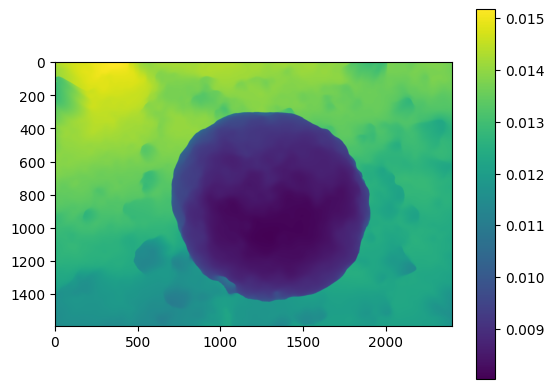

In [119]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

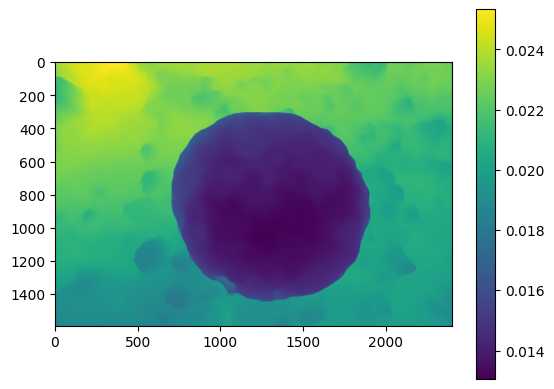

In [120]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

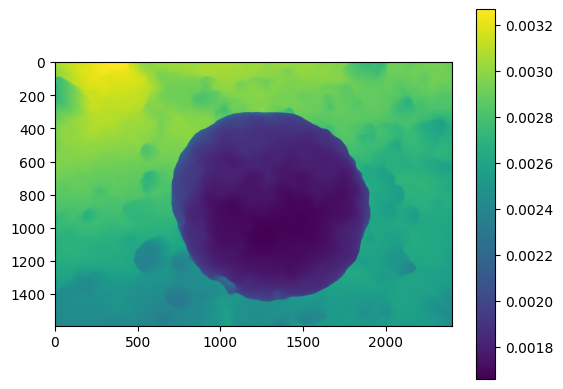

In [121]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

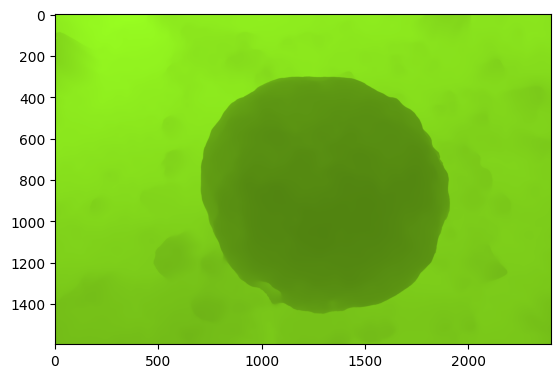

In [122]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012064328893614008..0.8690132140984734].


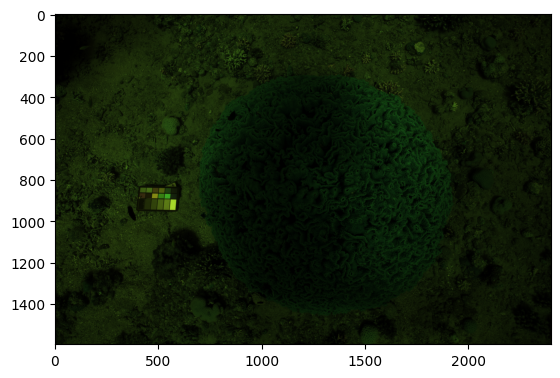

In [123]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

plt.imshow(direct_signal)

In [124]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [125]:
epsilon = 0.1065607
convergence_threshold = 0.001
f = 2.0

In [126]:
def pad_depths(depths: np.ndarray) -> np.ndarray:
    height, width = depths.shape

    depths_padded = np.zeros((height + 2, width + 2), dtype=depths.dtype) + np.inf
    depths_padded[1:-1, 1:-1] = depths

    return depths_padded

def calculate_neighborhood_map(depths: np.ndarray, epsilon: float) -> np.ndarray:
    height, width = depths.shape
    nmap = np.zeros((height, width, 3, 3), dtype=bool)

    mask = np.zeros((3, 3), dtype=bool)
    mask[1, 0] = True
    mask[0, 1] = True
    mask[1, 1] = True
    mask[1, 2] = True
    mask[2, 1] = True

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            x_min = x - 1
            x_max = x + 2
            y_min = y - 1
            y_max = y + 2

            nmap[y, x, :, :] = np.logical_and((np.abs(depths[y_min:y_max, x_min:x_max] - depths[y, x]) <= epsilon), mask)

    return nmap

In [127]:
padded_tif = pad_depths(tif)
neighborhood_map = calculate_neighborhood_map(padded_tif, epsilon)

# neighborhood_map.sum()

In [128]:
def update_a_prime(a_values: np.ndarray, neighborhood_map:np.ndarray):
    height, width, _, _ = neighborhood_map.shape

    a_prime = np.zeros_like(a_values)
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            x_min = x - 1
            x_max = x + 2
            y_min = y - 1
            y_max = y + 2

            if not np.any(neighborhood_map[y, x, :, :]):
                print("uh oh")

            a_prime[y, x, :] = a_values[y_min:y_max, x_min:x_max, :][neighborhood_map[y, x, :, :]].mean(axis=0)

    return a_prime

def update_a_values(D: np.ndarray, a_prime: np.ndarray, p: float = 0.1):
    return D * p + a_prime[1:-1, 1:-1, :] * (1 - p)

In [129]:
a_values = np.zeros((height + 2, width + 2, 3), dtype=np.float64) # We have more than one class than the total count b/c we did not use 0
prev_a_values = np.ones_like(a_values)

while np.any(np.abs(a_values - prev_a_values) >= convergence_threshold):
    print(np.abs(a_values - prev_a_values).max())

    prev_a_values = a_values.copy()

    a_prime = update_a_prime(a_values, neighborhood_map)
    a_values[1:-1, 1:-1, :] = update_a_values(direct_signal, a_prime)

    print(np.abs(a_values - prev_a_values).max())

1.0
0.08690132140984735
0.08690132140984735
0.07757488655818054
0.07757488655818054
0.06965222938564825
0.06965222938564825
0.0626252564249139
0.0626252564249139
0.05631621194400038
0.05631621194400038
0.05065502383173415
0.05065502383173415
0.045565276270317034
0.045565276270317034
0.04098779617576359
0.04098779617576359
0.03686881996594932
0.03686881996594932


KeyboardInterrupt: 

In [34]:
a_prime = a_prime[1:-1, 1:-1, :]
a_values = a_values[1:-1, 1:-1, :]

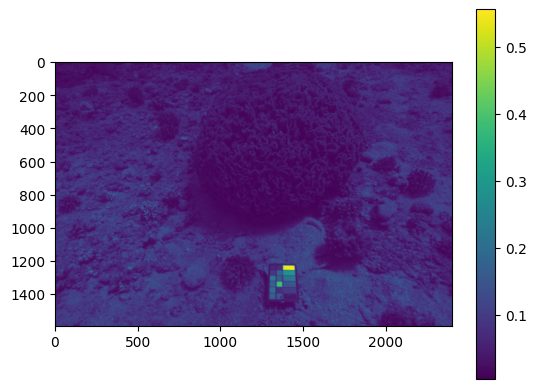

In [ ]:
imshow(a_prime[:, :, 0])

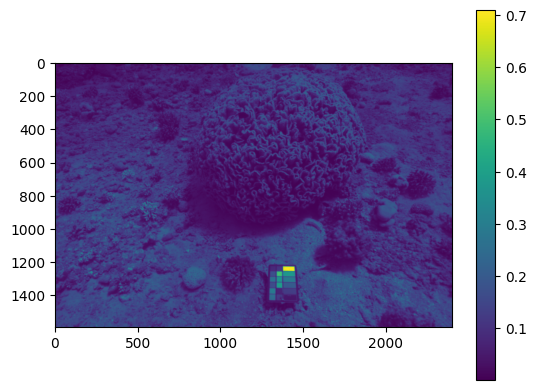

In [ ]:
imshow(a_prime[:, :, 1])

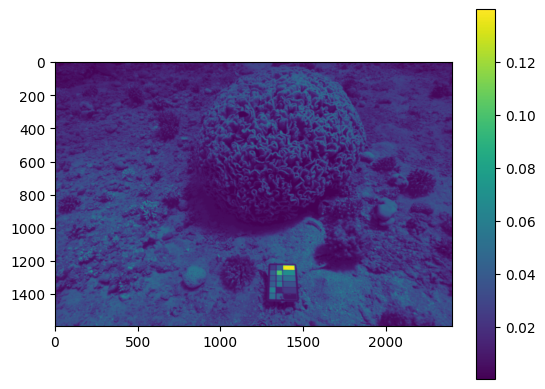

In [ ]:
imshow(a_prime[:, :, 2])

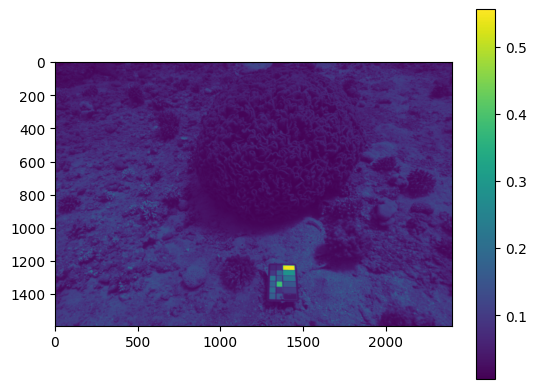

In [ ]:
imshow(a_values[:, :, 0])

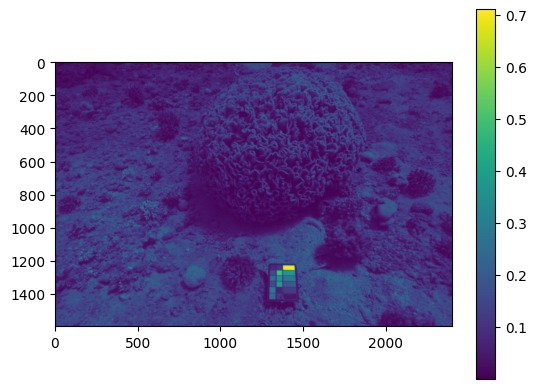

In [ ]:
imshow(a_values[:, :, 1])

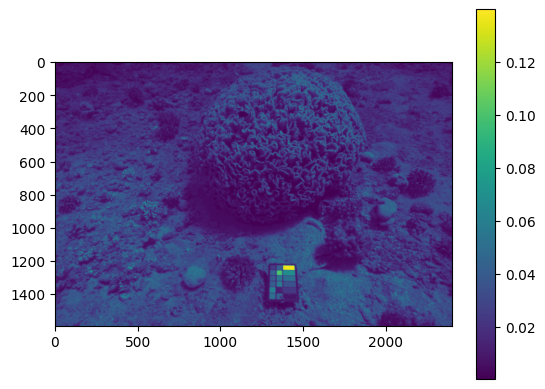

In [ ]:
imshow(a_values[:, :, 2])

1.4205876124492556


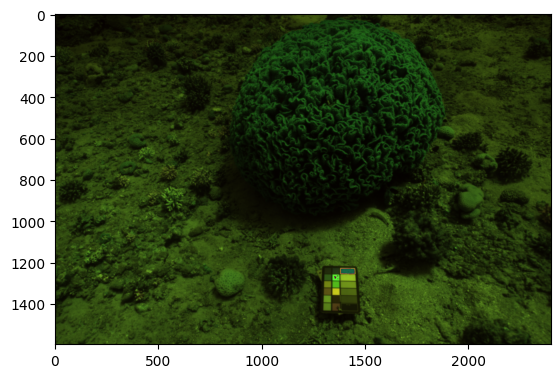

In [ ]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map)

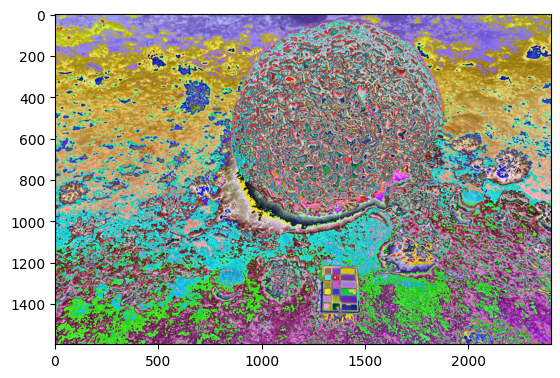

In [ ]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

imshow(beta_d_coarse)

### Refined Estimate of $\beta_c^D(z)$

In [43]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [44]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> float:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [45]:
def leastsquares_compute_beta_D(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int, starts=50):
    lo = np.array([0, -np.inf, 0, -np.inf])
    hi = np.array([np.inf, 0, np.inf, 0])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4) * 2000
        starting_point[1] /= -10
        starting_point[3] /= -10

        print(starting_point)

        try:
            result = least_squares(optimize_compute_beta_D, starting_point, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        result = optimize_compute_beta_D(params, local_illuminant_map[:, :, color_channel], depths)
        max_diff = np.abs(result).max()
        loss = (np.abs(result)).mean()

        print(loss, max_diff, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [ ]:
local_illuminant_params_b, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 0)

local_illuminant_params_b, loss # 0.285

[ 1.77543681e+03 -6.35526793e+01  7.78901696e+02 -1.14674316e+00]
0.3793769948487928 3.2517560465354567 [ 8.89385562 -1.60992678  0.98671424 -0.12147755]
[ 705.24463723  -85.18649957 1231.16621562  -80.31139446]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


[1499.50813155 -153.04656126 1175.48901671 -123.84682797]
[1319.54083292  -99.12399722 1502.2878455   -17.43256968]
1.607847331883134e+17 5.8448231819115705e+20 [ 2.11223259e+14 -1.83796948e+01  7.04424800e+16 -1.67081128e+01]
[1767.53972888 -151.67326957 1052.79654414 -173.84750426]
[ 867.98876332  -71.70272527 1959.31177942  -88.68709437]


/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


[1052.55022707  -99.41534892 1990.19860057 -194.21827071]
[ 713.68968156 -148.99008369 1593.18199884   -6.30579976]
0.4303310478022138 3.5410279057622738 [ 7.13689682e+02 -8.14628090e+03  2.82947527e+00 -3.78461191e-01]
[1264.77714654 -167.11863056  461.54727664  -73.31764724]
[1681.62968207 -154.11990133 1380.04647173 -177.19627602]
[ 960.45218832  -69.1009403  1135.12647719   -7.29196093]
1.7847245866772286 27.1726059886187 [ 9.60452188e+02 -2.78483772e+13  4.06484252e+14 -7.05709614e+00]
[ 9.03665710e+02 -6.20910007e+00  3.58389743e+02 -1.42153944e-01]
0.37937706890616174 3.251748275850142 [ 8.89404163 -1.60995063  0.98673228 -0.12148155]
[ 680.21050649  -37.04486946  709.14926084 -162.58340901]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  alpha = max(0.001 * alpha_upper, (alpha_lower * alpha_upper)**0.5)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/chris/.cache/

9.283156010808369e+75 1.200480608073015e+80 [ 680.21050649  -37.04486946  709.14926084 -162.58340901]
[1339.71196391  -29.52878037 1495.43843943 -130.65058932]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  p *= Delta / norm(p)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)


1.1794024963344372e+59 1.1063913618235564e+63 [1339.71196391  -29.52878037 1495.43843943 -130.65058932]
[1125.74634114   -6.16904256 1346.23217136  -72.08490534]
0.4303315401122381 3.5409796804958606 [ 2.82947799e+00 -3.78460241e-01  1.34623217e+03 -7.20849053e+01]
[ 749.72189183 -140.79262969 1278.78912505 -194.8518851 ]
[ 378.59758623 -137.87413207  513.42056485 -186.11694142]
[525.46409498 -62.68093606   1.72993214 -28.12517748]
7.339080601922337e+58 6.405519178340366e+62 [525.46409498 -62.68093606   1.72993214 -28.12517748]
[  30.69555194   -2.79914196 1804.70506118  -47.64629415]
0.430331026559572 3.5410327942795536 [ 2.82947672e+00 -3.78461411e-01  1.80470506e+03 -4.76462942e+01]
[1752.682142    -11.16258612  793.72051564 -165.00786426]
45262.57088040699 67548117.14556618 [ 3.39721725e+16 -1.07576439e+01  7.93720516e+02 -1.65007864e+02]
[ 352.55194109  -72.0791926  1333.90906534 -153.27081628]
[ 274.86301309  -57.94052604 1126.66351612  -43.53261532]
1.2732896654175375e+90 2.0454

(array([ 8.89385562, -1.60992678,  0.98671424, -0.12147755]),
 np.float64(0.3793769948487928))

In [47]:
local_illuminant_params_g, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 1)

local_illuminant_params_g, loss #0.412

[1621.53002565 -160.91586012 1765.88177311 -183.38039371]
[  27.64278786 -189.28951197 1171.34926788 -193.14931152]
[1427.04029391 -139.46790589 1285.46319675 -151.10642531]


/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:298: RuntimeWarning: overflow encountered in multiply
  J_augmented[:m] = J * d


[1105.43479084 -111.09986065 1793.20131833  -86.7968281 ]
[ 375.39342012  -89.72629253  220.10498586 -105.1867755 ]
[ 948.05624643 -192.01042955  805.93841675  -49.0965031 ]
3.309777903808652e+102 6.578301230983532e+106 [ 948.05624643 -192.01042955  805.93841675  -49.0965031 ]
[1385.88620218  -48.29921261 1606.87742087  -20.14663755]
82300.12829665956 386089316.1651311 [ 1.38588620e+03 -2.04156909e+15  1.34496573e+33 -1.85631158e+01]
[ 538.42371147 -198.45040499  957.57422635  -64.77335754]
1.6405133638552912e+137 4.584895526133908e+141 [ 538.42371147 -198.45040499  957.57422635  -64.77335754]
[1330.64913284 -193.29609951  620.72176254  -37.49396453]
8.759560537122518e+76 1.2258105625860281e+81 [1330.64913284 -193.29609951  620.72176254  -37.49396453]
[ 765.86215695  -96.46464628 1871.07133231 -168.24820143]
[1405.19261694 -163.23689458  394.20644866  -12.67505671]
96554.76372624043 174574061.7846955 [ 1.40519262e+03 -1.34043853e+13  8.42971423e+17 -1.15828488e+01]
[1098.95902693  -71.

(array([ 8.84936203e+02, -9.98634235e+06,  2.35174254e+00, -3.46690392e-01]),
 np.float64(0.5693279221865025))

In [ ]:
local_illuminant_params_r, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 2)

local_illuminant_params_r, loss #208

[1349.12728361  -61.09152578  147.97452762  -57.10692646]


1.9996496721777252e+121 4.219483435780844e+125 [1349.12728361  -61.09152578  147.97452762  -57.10692646]
[ 703.60750177  -63.10985087 1510.05322226  -25.01422214]
1.2576868513013366e+17 6.246159487332867e+20 [ 7.03607502e+02 -3.54479516e+14  3.01507963e+26 -2.09563572e+01]
[1682.13166131 -161.71562852 1058.16145501  -52.39079934]
9.789173240865153e+109 1.8465242000638315e+114 [1682.13166131 -161.71562852 1058.16145501  -52.39079934]
[1980.80837745 -100.09761912 1092.50854054 -181.97411017]
[1823.17263433  -46.56640801 1292.57323862  -34.13799381]
3.1731914164888585e+69 3.340262895949363e+73 [1823.17263433  -46.56640801 1292.57323862  -34.13799381]
[1097.47483167  -10.6528676  1744.81962236 -111.0883924 ]
34942.65890381643 46501160.537697144 [ 1.81574836e+16 -1.04738426e+01  1.74481962e+03 -1.11088392e+02]
[1134.56555606 -117.51185407 1761.56389395 -149.00942334]
[ 561.91328908 -132.38569512 1550.112451   -179.51345602]
[1735.01594587 -107.18780535 1571.26961779 -191.31430948]
[ 832.805

/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_16421/1235797028.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


61075.16858311168 250876901.4786864 [ 1.01564645e+34 -1.87704975e+01  1.02047373e+03 -4.68885448e+01]
[   3.82853096  -30.05496756  735.2433255  -192.05133352]
1.0366744984494771e+63 9.07426469492716e+66 [   3.82853096  -30.05496756  735.2433255  -192.05133352]
[ 867.31154837 -179.6878375    59.76476362 -130.1626102 ]
[ 748.3902278  -143.36383069 1600.86890999  -55.47592715]
4.469380571287516e+116 9.083615410524712e+120 [ 748.3902278  -143.36383069 1600.86890999  -55.47592715]
[1610.85656216  -69.14195111 1025.04274313 -126.88234391]
9.223798565874192e+146 2.4819285157424056e+151 [1610.85656216  -69.14195111 1025.04274313 -126.88234391]
[ 638.24379429 -199.20780086 1664.2928583   -65.0804215 ]
8.655086168912878e+137 2.1582665311933453e+142 [ 638.24379429 -199.20780086 1664.2928583   -65.0804215 ]
[1077.26375447 -168.39072549  744.30565417 -101.05884572]
[ 128.30911015  -35.02837048 1671.07765537 -154.239356  ]
2.9649643881226064e+72 3.237223493742856e+76 [ 128.30911015  -35.02837048 16

(array([10.02013035, -1.50806684,  1.56231312, -0.12825382]),
 np.float64(0.2991666731106708))

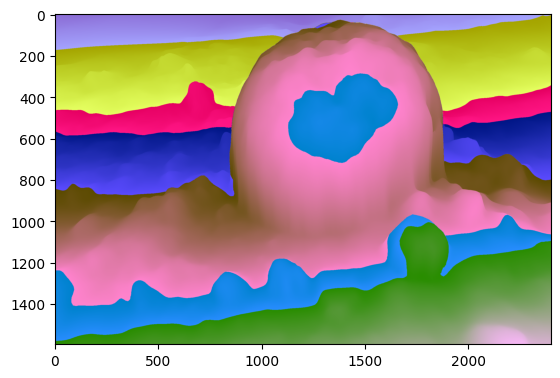

In [ ]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

imshow(beta_d)

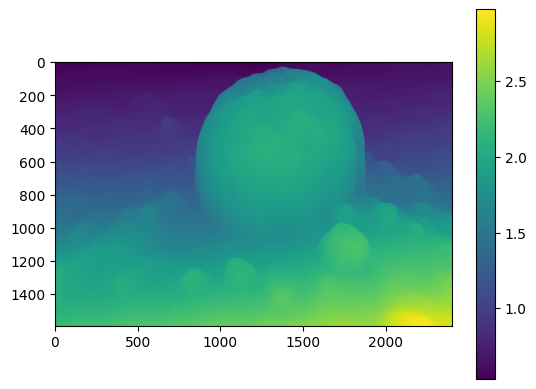

In [ ]:
imshow(beta_d[:, :, 0])

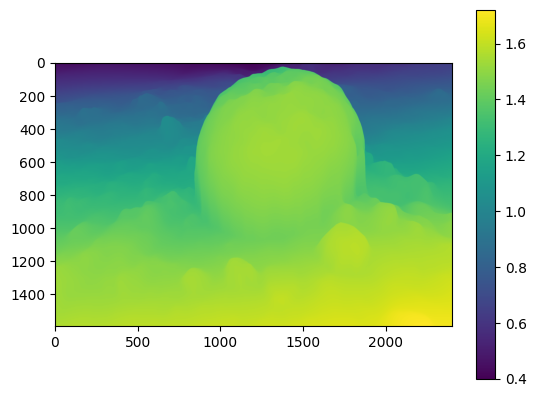

In [ ]:
imshow(beta_d[:, :, 1])

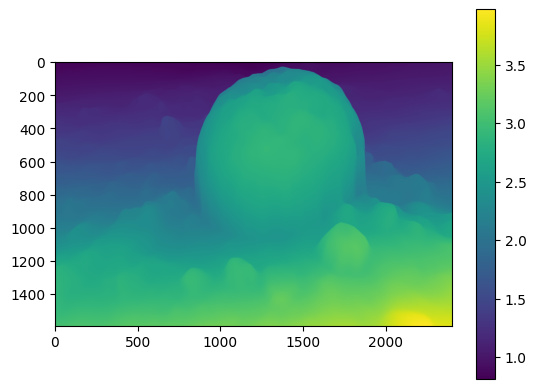

In [ ]:
imshow(beta_d[:, :, 2])

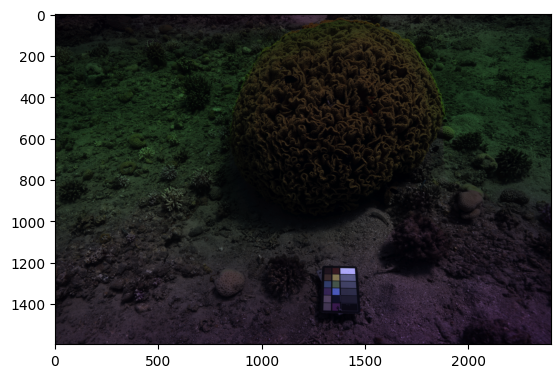

In [ ]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

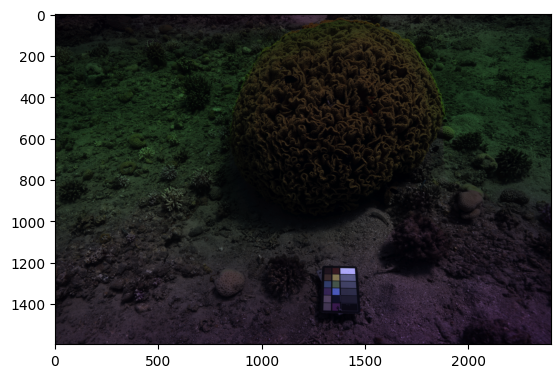

In [ ]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [55]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [56]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

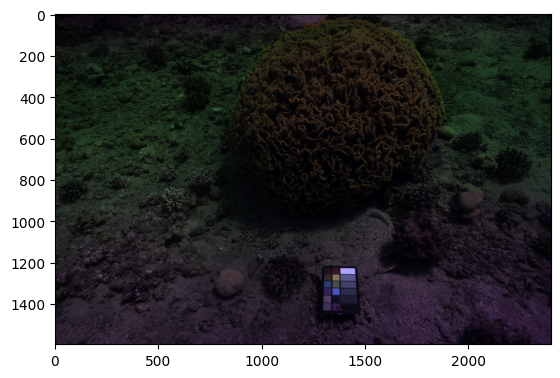

In [ ]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [58]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

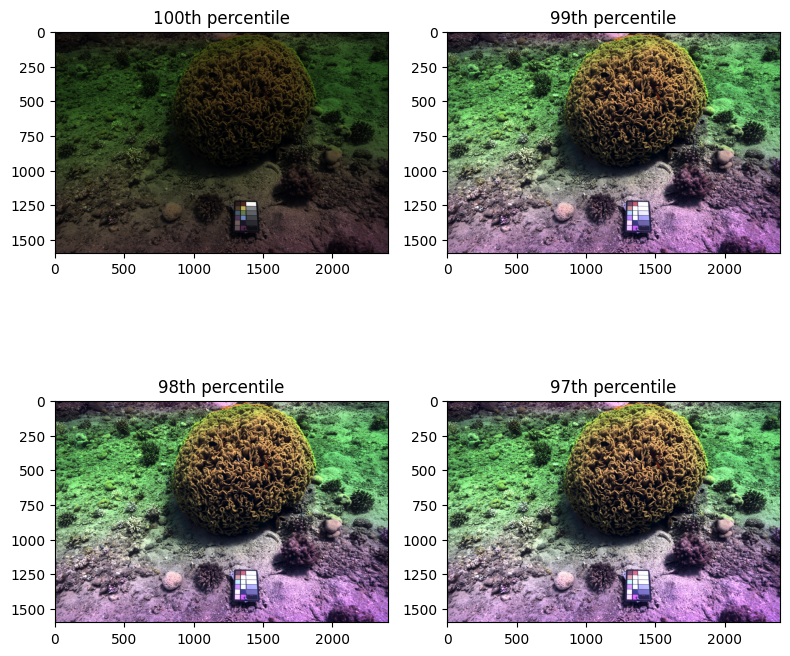

In [ ]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

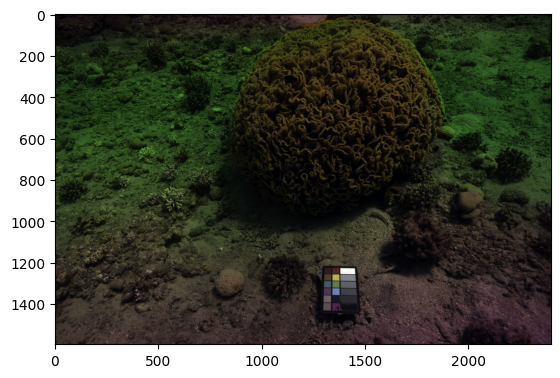

In [ ]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

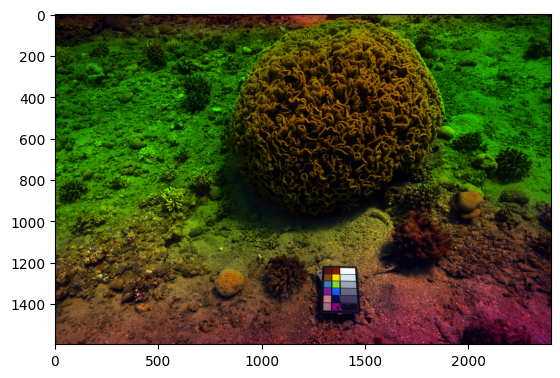

In [ ]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

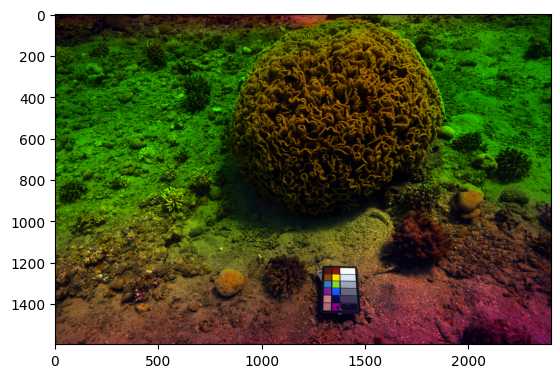

In [ ]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

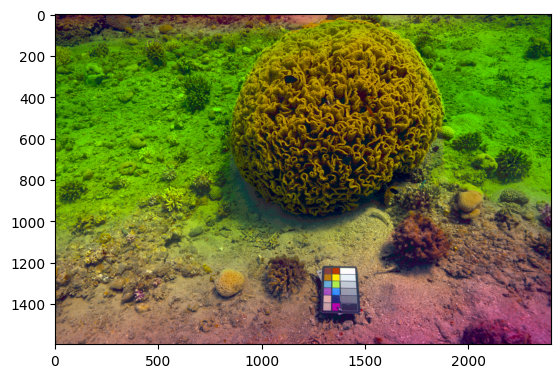

In [ ]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

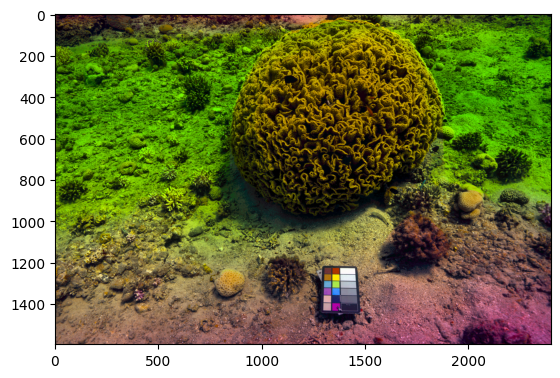

In [ ]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [ ]:
cv2.imwrite("output/crutchfield2_final.png", img_as_ubyte(img_hist))

True